# Predicting personality (HEXACO) using emotional EEG

In [1]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import normalize
from itertools import combinations
from mne.time_frequency import tfr_morlet
plt.style.use('seaborn-whitegrid')

# Load Hexaco result. Our Groud Truth

In [2]:
plt.style.use('seaborn-whitegrid')

df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')
labels = []
for i in gt.index:
    labels.append(np.argmax(gt[['h','e','x','a','c','o']].loc[i]))
gt['label'] = labels
gt

,h,e,x,a,c,o,label
id,,,,,,,
2,3.63,3.19,2.94,2.38,3.38,2.38,0
3,3.38,3.44,3.50,3.50,4.50,3.81,4
4,3.19,3.75,3.69,3.19,2.63,2.63,1
5,3.25,3.63,2.13,3.56,3.63,2.31,1
6,3.25,2.75,3.50,2.50,3.75,5.00,5
7,4.06,3.06,3.38,2.88,2.50,4.19,5
8,3.94,2.94,3.19,3.75,3.38,3.81,0
9,4.44,4.00,3.38,3.75,3.69,3.31,0
10,3.63,3.25,3.50,3.31,3.88,2.69,4


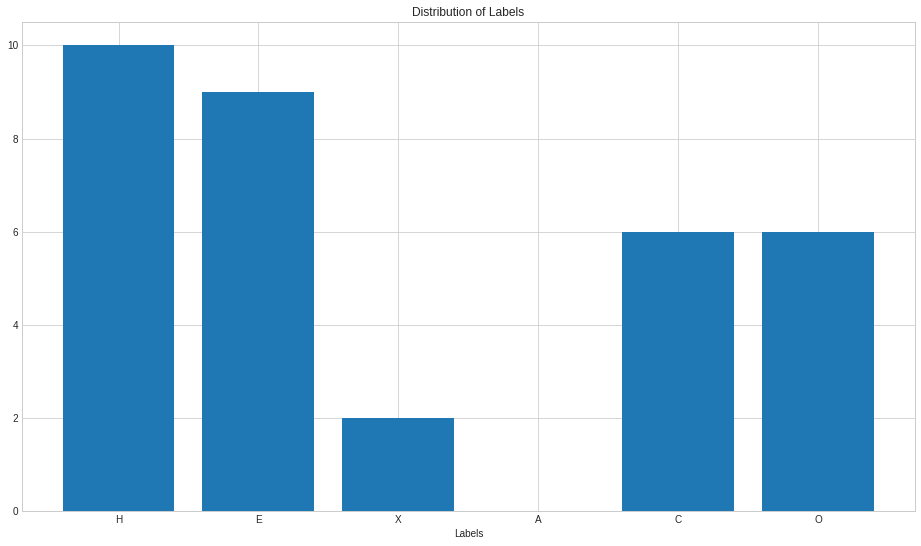

In [22]:
count, _ =np.histogram(gt['label'], bins = 6)

fig, ax = plt.subplots(figsize=(16,9))
ax.bar(['H','E','X','A','C','O'],count)
ax.set_title("Distribution of Labels")
ax.set_xlabel("Labels")
# ax.set_ylabel("Distribution of Labels")
plt.show()

Extract for every image samples.

There are 

In [ ]:
# Preprocess data + feature extraction using wavelet 'morlet'
def get_data_wt(eeg_type = 'image'):
    X = None
    y = []
    # 'DELTA' 'THETA' 'ALPHA' 'BETA' 'Gamma'
    filter_list = np.array([4,8,13,30,125])
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in ids:
        # print('\n',"="*20,id)
        if(eeg_type == 'image'):
            raw = dataframe_to_raw(EEG_image[id], sfreq=250)
        else:
            raw = dataframe_to_raw(EEG_audio[id], sfreq=250)
        raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
        raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift
        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
        events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
        if(events.shape[0] != 50):
            raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
        epochs = mne.Epochs(raw, events, tmin=0.3, tmax=5.8, baseline=(0.3,0.3), verbose=False)
        if(epochs.get_data().shape[0] != 50):
            raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

        powers = tfr_morlet(epochs, freqs=filter_list, n_cycles=filter_list / 2., return_itc=False, average=False, verbose=False)
        features = np.mean(powers.data, axis=3)
        for e in range(features.shape[0]):
            row = np.expand_dims(features[0].reshape(-1), axis=0)
            row = 10 * np.log10(row)
            if(type(X) == type(None)): X = row
            else: X = np.concatenate( [X, row ], axis=0 )
            y.append(gt.loc[id]['label'])
    y = np.array(y)
    return X,y

In [ ]:
def get_acc(X,y):
    X_copy = X.copy()
    X_norm = normalize(X_copy, axis=0)
    
    gnb = GaussianNB()
    gnb.fit(X_norm, y)  
    pred = gnb.predict(X_norm)
    acc = sum(y == pred)/len(y)
    return acc, gnb